<a href="https://colab.research.google.com/github/tylee33/DLforFinance/blob/master/Basic_EDA_of_S%26P500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import numpy, matplotlib as np, plt and set %matplotlib inline amongst other imports...
%pylab --no-import-all inline

# table and graphical visualisation
import pandas  as pd
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format

Populating the interactive namespace from numpy and matplotlib


In [0]:
data = pd.read_csv('./all_stocks_1yr.csv', parse_dates = ['Date'])

In [3]:
# Explore nulls...
data.isnull().sum()

Date        0
Open      380
High      206
Low       224
Close       0
Volume      0
Name        0
dtype: int64

In [4]:
# Explore where the nulls are...
data.loc[data.isnull().sum(axis = 1).astype(bool)].nunique()

Date        2
Open        0
High      172
Low       156
Close     375
Volume    380
Name      380
dtype: int64

In [5]:
# Get dates...
dates = data.loc[data.isnull().sum(axis = 1).astype(bool)]['Date'].unique()

# Drop...
data.drop(np.arange(len(data))[data['Date'].isin(dates)], inplace = True)

# Re-check for nulls...
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [6]:
# Preview Data...
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2016-08-12,181.47,181.47,179.90,180.27,1232856,MMM
1,2016-08-15,181.00,181.39,180.46,180.56,1268247,MMM
2,2016-08-16,180.12,180.33,179.21,179.25,1363554,MMM
3,2016-08-17,178.67,180.09,178.32,179.87,1358528,MMM
4,2016-08-18,179.70,179.70,178.58,179.18,1088677,MMM


In [7]:
# Verify count of each company using np.unique...
# Using a nested np.unique like this returns the unique count of days in
# the first array and the count of those unique days in the second array
np.unique(np.unique(data['Name'], return_counts = True)[1], return_counts = True)

(array([ 18,  26, 100, 143, 172, 250]), array([  1,   1,   1,   1,   1, 499]))

In [8]:
# Verify number of companies...
data['Name'].nunique()

504

In [0]:
loc = data['Name'].isin(np.unique(data['Name'])[np.unique(data['Name'], return_counts = True)[1] < 250])
data.drop(loc.index[loc], inplace = True)

In [11]:
# Re-verify count of each company...
np.unique(np.unique(data['Name'], return_counts = True)[1], return_counts = True)

(array([250]), array([499]))

In [0]:
# Obtain all names to corresponding close...
name, close = data[data['Date'] == data['Date'].min()][['Name', 'Close']].T.values

# Map to dictionary...
base = {n : c for n, c in zip(name, close)}

# Use base to add Growth to data...
Base           = np.array(list(map(lambda x : base[x], data['Name'].values)))
data['Growth'] = data['Close'] / Base - 1

In [13]:
# Summary statistics...
data['Growth'].describe()

count   124750.00
mean         0.06
std          0.19
min         -0.74
25%         -0.05
50%          0.02
75%          0.14
max          1.73
Name: Growth, dtype: float64

In [14]:
# change to an integer of your choice
# large n will cause the later visualisation to slow down
n = 8

# last day of the year for all companies only showing Date, Name and Growth sorted by Growth...
obj = data.loc[251::250][['Date', 'Name', 'Growth']].sort_values('Growth')

print('Largest fall in share price:')
display(obj.head(n))
print('Largest gain in share price:')
display(obj.tail(n))

Largest fall in share price:


,Date,Name,Growth
59039,2017-08-11,HLT,-0.72
97847,2017-08-11,RRC,-0.57
114372,2017-08-11,UAA,-0.55
114120,2017-08-11,UA,-0.55
75923,2017-08-11,MAT,-0.49
73907,2017-08-11,M,-0.48
83483,2017-08-11,NFX,-0.45
69623,2017-08-11,LB,-0.45


Largest gain in share price:


,Date,Name,Growth
34067,2017-08-11,CSX,0.79
121680,2017-08-11,WDC,0.80
5291,2017-08-11,ALGN,0.81
2015,2017-08-11,AMD,0.82
78695,2017-08-11,MU,0.88
86759,2017-08-11,NRG,0.94
65339,2017-08-11,JEC,0.96
87263,2017-08-11,NVDA,1.47


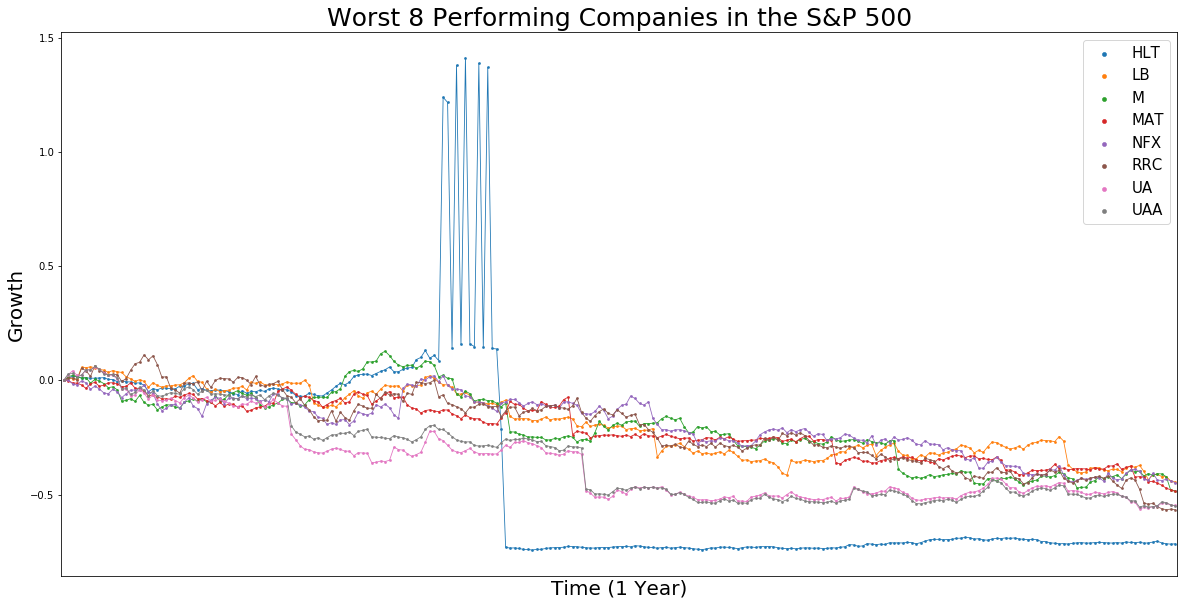

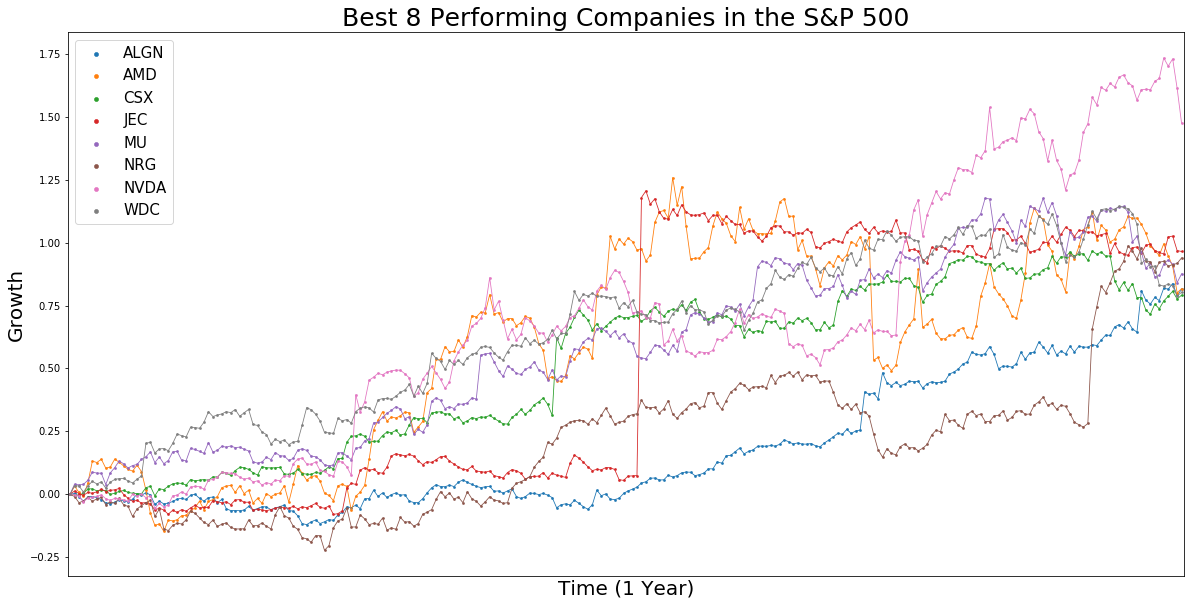

In [15]:
lo_names = obj.head(n)['Name']
hi_names = obj.tail(n)['Name']
names    = [lo_names, hi_names]
pre      = ['Worst', 'Best']
title    = ' {} Performing Companies in the S&P 500'.format(n)

for i in range(2):
    # subset of data...
    sub = data[data['Name'].isin(names[i])].groupby(['Name', 'Date'])['Growth'].sum().reset_index()
    
    # create figure...
    plt.figure(figsize(20, 10))
    
    sns.pointplot(x = 'Date', y = 'Growth', hue = 'Name', data = sub, scale = 0.3)
    
    # remove the 250 x ticks...
    plt.xticks([])
    
    # add title and x / y labels 
    plt.title(pre[i] + title  , size = 25)
    plt.xlabel('Time (1 Year)', size = 20)
    plt.ylabel('Growth'       , size = 20)
    
    # always add a legend and make sure it is readable
    plt.legend(markerscale = 2, prop = {'size' : 15})
    
    plt.show()

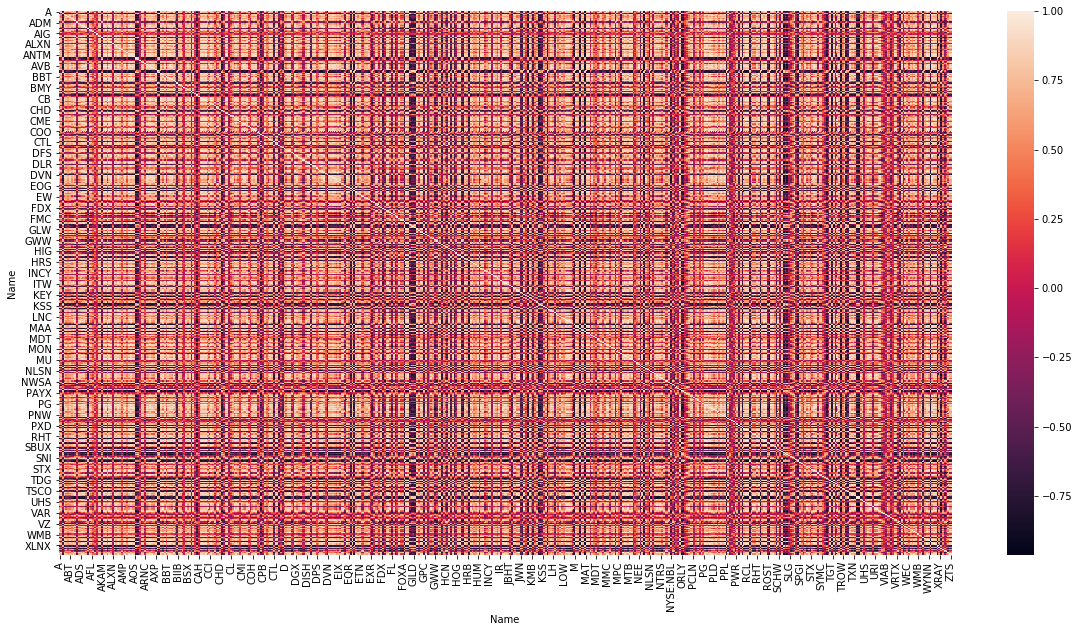

In [16]:
cor = data.pivot('Date', 'Name', 'Growth').corr()
sns.heatmap(cor)
plt.show()

In [0]:
def get_correlation(cor, upper = 0.99, lower = -0.99, blank = False):
    corr = {}
    for i in cor:
        obj = cor[i][cor[i].apply(abs).argsort()[::-1]]
        obj = obj[(obj > upper) | (obj < lower)]
        obj = obj[obj.index != i]
        if len(obj) == 0:
            if blank: corr[i] = None
        else:
            corr[i] = {}
            for j in obj.index:
                corr[i][j] = cor[i].loc[j]
    return corr

In [18]:
corr = get_correlation(cor, lower = -1)
corr

{'BAC': {'JPM': 0.9912098774907511},
 'CMS': {'XEL': 0.9907375876719124},
 'DD': {'DOW': 0.9937353017854293},
 'DISCA': {'DISCK': 0.9942041931381889},
 'DISCK': {'DISCA': 0.9942041931381889},
 'DOW': {'DD': 0.9937353017854293},
 'FOX': {'FOXA': 0.9950666836940044},
 'FOXA': {'FOX': 0.9950666836940044},
 'GOOG': {'GOOGL': 0.9988239928818068},
 'GOOGL': {'GOOG': 0.9988239928818068},
 'HBAN': {'RF': 0.9910682393035773},
 'JPM': {'BAC': 0.9912098774907511},
 'MS': {'PNC': 0.9903886723556541},
 'NWS': {'NWSA': 0.9966253542968968},
 'NWSA': {'NWS': 0.9966253542968968},
 'PNC': {'MS': 0.9903886723556541, 'UNM': 0.9916298674678535},
 'RF': {'HBAN': 0.9910682393035773},
 'UA': {'UAA': 0.9902675205979965},
 'UAA': {'UA': 0.9902675205979965},
 'UNM': {'PNC': 0.9916298674678535},
 'XEL': {'CMS': 0.9907375876719124}}

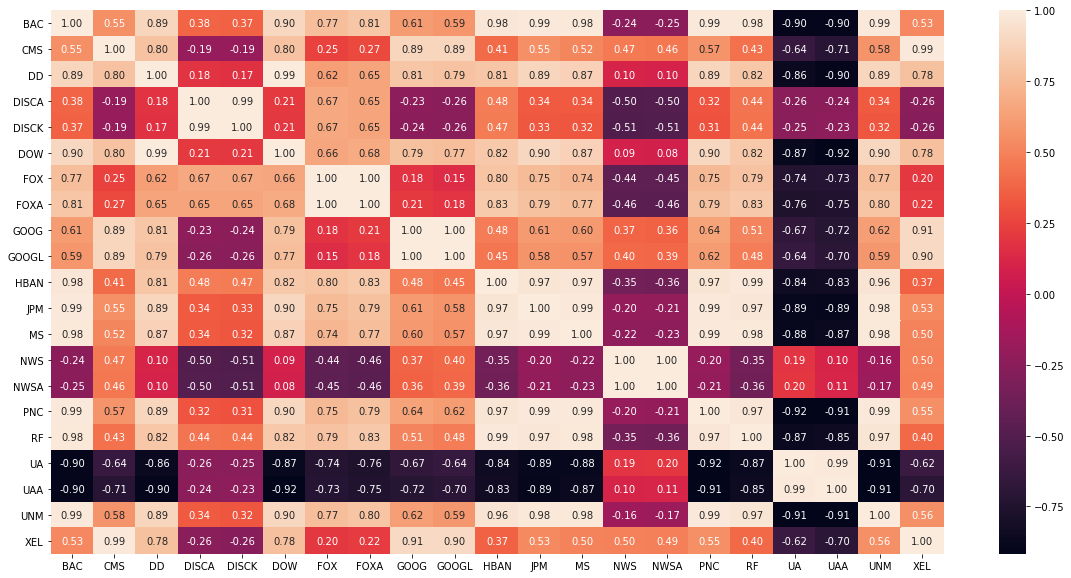

In [19]:
sns.heatmap(cor.loc[list(corr), list((corr))], annot = True, fmt = '.2f')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [20]:
# And try for negative correlation...
corr = get_correlation(cor, upper = 1, lower = -0.95)
corr

{'ALL': {'MAT': -0.9622517819726366, 'RRC': -0.9536556485611671},
 'ANTM': {'MAT': -0.9515083226881715},
 'APH': {'RRC': -0.9505915603135734},
 'AZO': {'COO': -0.9555744449082818},
 'CCL': {'MAT': -0.9567373898153909, 'RRC': -0.953199502767193},
 'COO': {'AZO': -0.9555744449082818},
 'GD': {'TRIP': -0.9540257402132809},
 'HRS': {'TRIP': -0.952566502179974},
 'KIM': {'LRCX': -0.950668211537518},
 'LRCX': {'KIM': -0.950668211537518},
 'MA': {'RRC': -0.9599170461573412},
 'MAT': {'ALL': -0.9622517819726366,
  'ANTM': -0.9515083226881715,
  'CCL': -0.9567373898153909,
  'RCL': -0.960493562371796,
  'RE': -0.9512302933270755,
  'ROP': -0.9563735244932748},
 'RCL': {'MAT': -0.960493562371796, 'RRC': -0.953300758601956},
 'RE': {'MAT': -0.9512302933270755, 'RRC': -0.9594483703388802},
 'ROP': {'MAT': -0.9563735244932748},
 'RRC': {'ALL': -0.9536556485611671,
  'APH': -0.9505915603135734,
  'CCL': -0.953199502767193,
  'MA': -0.9599170461573412,
  'RCL': -0.953300758601956,
  'RE': -0.95944837

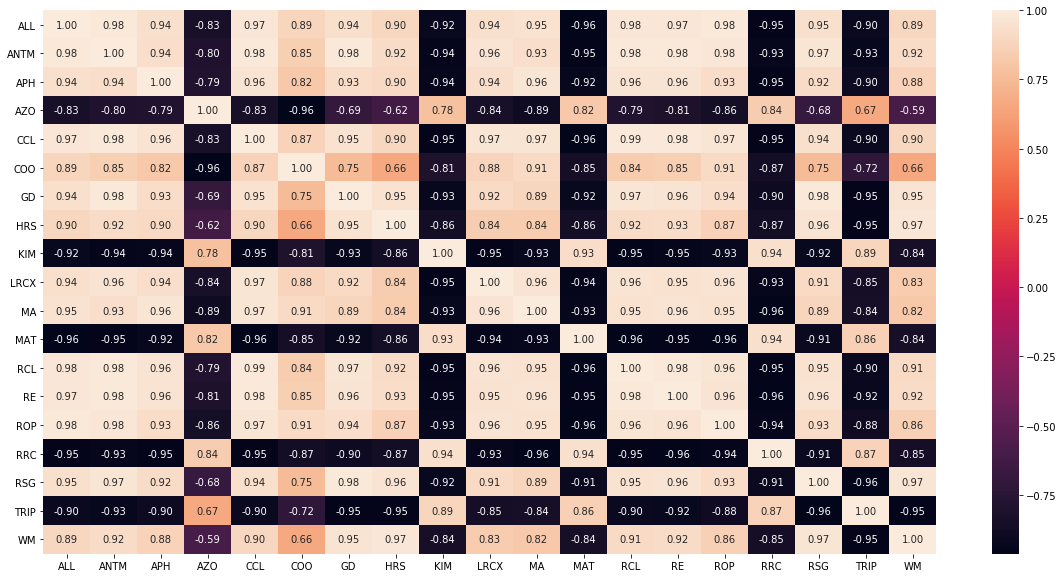

In [21]:
sns.heatmap(cor.loc[list(corr), list((corr))], annot = True, fmt = '.2f')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [22]:
obj['Growth'].sum(), obj['Growth'].mean()

(55.1806586308251, 0.11058248222610244)